Let's load the datasets prepared in Part 1:

In [56]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv')
train_from_part_1 = pd.read_csv('new_datasets/train_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_from_part_1 = pd.read_csv('new_datasets/test_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')

CPU times: total: 766 ms
Wall time: 1 s


In this part we'll work with the 'emission' time series, calculating trend, seasonality, cycles, etc. Therefore, we need a new method for comparing performances of our models.

We'll separate our training set from part 1 on a training and cross-validation set. Cross-validation set will include several last observations from all the Locations.

In testing a new feature, we'll first calculate this feature on a training set, then predict it on a cross-validation set and calculate cross-validation RMSE. 

If we see improvements (Cross-val RMSE goes down), then we keep the new feature.

For the submission, we'll recalculate the new feature on the whole training set and predict on the test set.

Let's divide the training set from the part 1:

In [68]:
# Calculate the proportion of test set weeks compared to the total number of weeks
proportion = len(test_from_part_1) / (len(train_from_part_1) + len(test_from_part_1))

# Calculate the desired amount of weeks in the cross-validation set
train_from_part_1_weeks = len(train_from_part_1['WeekCount'].unique())
cv_weeks = round(train_from_part_1_weeks * proportion)
train_weeks = train_from_part_1_weeks - cv_weeks
test_weeks = len(test_from_part_1['WeekCount'].unique())

print('Weeks in the training set: {}'.format(train_weeks))
print('Weeks in the cross-validation set: {}'.format(cv_weeks))
print('Weeks in the test set: {}'.format(test_weeks))

# Create training and cross-validation sets
train = pd.DataFrame(train_from_part_1.loc[train_from_part_1['WeekCount'] < train_weeks, :])
cv = pd.DataFrame(train_from_part_1.loc[train_from_part_1['WeekCount'] >= train_weeks, :])

print("The last 5 rows of the cross-validation set:")
cv.tail()

Weeks in the training set: 122
Weeks in the cross-validation set: 37
Weeks in the test set: 49
The last 5 rows of the cross-validation set:


,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,Location,Location_enc,WeekCount
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-3.299_30.301_2021_48,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,...,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,29.404171,-3.29930.301,28.150387,154
ID_-3.299_30.301_2021_49,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,...,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,29.186497,-3.29930.301,28.150387,155
ID_-3.299_30.301_2021_50,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,NaN,...,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,29.131205,-3.29930.301,28.150387,156
ID_-3.299_30.301_2021_51,-3.299,30.301,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,32.599393,...,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868,28.125792,-3.29930.301,28.150387,157
ID_-3.299_30.301_2021_52,-3.299,30.301,2021,52,-0.000091,0.871951,-0.000079,0.000000,76.825638,8.273742,...,19.464032,0.226276,-12.808528,47.923441,-136.299984,30.246387,27.239302,-3.29930.301,28.150387,158


## 00. Baseline

We'll use a separate scores DataFrame in this part, with RMSE as our scores. Let's calculate a new baseline, where emissions will be just the median emission (calculated on the training set):

In [58]:
study_number = '00'

from sklearn.metrics import mean_squared_error

# Calculate median emissions per Location for cv
location_median = train.groupby('Location')['emission'].median()

# Create predictions for train and cv
train_pred = train['Location'].map(location_median)
cv_pred = cv['Location'].map(location_median)

# Calculate train and cv RMSE
score_train = mean_squared_error(train['emission'], train_pred, squared=False)
score_cv = mean_squared_error(cv['emission'], cv_pred, squared=False)

# Calculate median emissions per Location for test
location_median = train_from_part_1.groupby('Location')['emission'].median()

# Create predictions for test
test_pred = test_from_part_1['Location'].map(location_median)

# Create a submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_from_part_1.index, 'emission': test_pred})

pd.concat([pd.DataFrame(test_from_part_1.index, columns=['ID_LAT_LON_YEAR_WEEK']),\
                        pd.DataFrame(test_pred, columns=['emission'])], axis=1)
submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)


In [59]:
# Create scores DataFrame
scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Cross-val RMSE': [], 'Test RMSE': []})

# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'Median per category'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = 72.19462

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Median per category,52.139869,26.803341,72.19462


## Exploring time series

Let's look at the 'emission' time series for every location that has median emissions above 95th quantile:

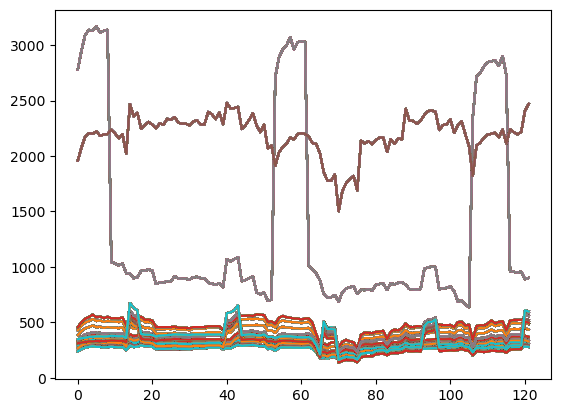

CPU times: total: 2.45 s
Wall time: 2.86 s


In [63]:
%%time

quantile = train['emission'].quantile(0.95)

import matplotlib.pyplot as plt

for location in train.loc[train['Location_enc'] > quantile, 'Location_enc']:
    series = train.loc[train['Location_enc'] == location, 'emission']
    plt.plot(range(len(series)), series)
plt.show()

We can see a few things here:

-) There seems to be a common trend

-) Sesonality is similar for most of the locations, except for the two with the highest emissions.

## 05. Common trend

Let's look at the median emissions time series across all locations:

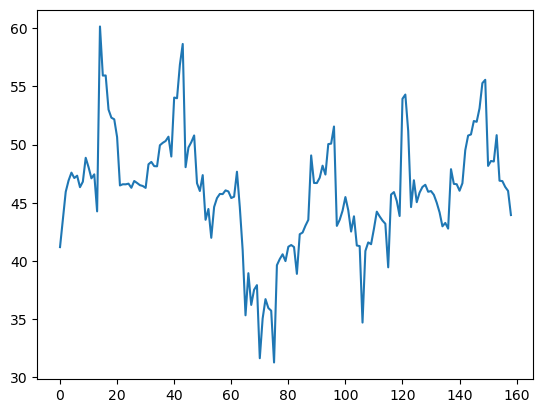

In [69]:
study_number = '01'

plt.plot(range(train_from_part_1_weeks), train_from_part_1.groupby('WeekCount')['emission'].median())
plt.show()

Let's calculate a common trend on the traning set:

In [88]:
%%time

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

# Calculate trend on the training set
dp = DeterministicProcess(index=range(train_weeks), constant=True, order=2, drop=True)
X = dp.in_sample()
y = train.groupby('WeekCount')['emission'].median()

lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)

y_train_pred = pd.Series(lr.predict(X), index=X.index)

train['CommonTrend'] = train['WeekCount'].map(y_train_pred)

# Continue trend on the cv set:

X = dp.out_of_sample(steps=49)

y_cv_pred = pd.Series(lr.predict(X), index=X.index)

cv['CommonTrend'] = cv['WeekCount'].map(y_cv_pred)

CPU times: total: 15.6 ms
Wall time: 14.2 ms


Let's look at the trend:

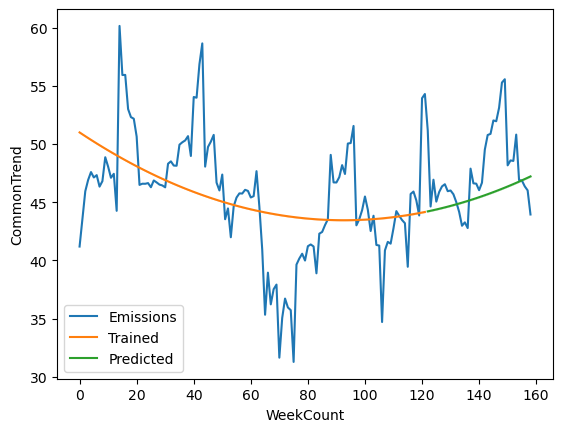

CPU times: total: 3.62 s
Wall time: 4.18 s


In [89]:
%%time

import seaborn as sns
ax = plt.plot(range(train_from_part_1_weeks), train_from_part_1.groupby('WeekCount')['emission'].median(), label='Emissions')
sns.lineplot(data = train, x='WeekCount', y='CommonTrend', label='Trained')
sns.lineplot(data = cv, x='WeekCount', y='CommonTrend', label='Predicted')
plt.legend()

plt.show()

Let's calculate the errors:

In [94]:
# Calculate scores
score_train = mean_squared_error(train['emission'], train['CommonTrend'], squared=False)
score_cv = mean_squared_error(cv['emission'], cv['CommonTrend'], squared=False)


# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'CommonTrend'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = 72.19462

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,CommonTrend,150.22271,143.983918,72.19462
1,CommonTrend,150.22271,143.983918,72.19462
